In [65]:
# PACKAGES
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model

In [4]:
def comp_vol(x):
    return np.sqrt(np.sum(x**2))

In [85]:
# TRIAL ALL TOGETHER
selected_stocks = [27, 100, 18, 62, 75, 9, 126, 97, 33, 80]
selected_time_ids = [4707, 30641, 103, 18491, 30023, 27361,  7270, 22300, 17377, 13148]
selected_vols = {}
selected_logr = {}
grouped_vol_aggs = []

for i in selected_stocks:
    stock = pd.read_csv(f"individual_book_train/stock_{i}.csv")

    stock['WAP'] = (stock['bid_price1'] * stock['ask_size1'] + stock['ask_price1'] * stock['bid_size1']) / (stock['bid_size1'] + stock['ask_size1'])
    stock['BidAskSpread'] = (stock['ask_price1'] / stock['bid_price1']) - 1

    df = []

    for time_id in selected_time_ids:
        data = stock[stock['time_id'] == time_id]
        sec = data['seconds_in_bucket'].values
        price = data['WAP'].values
        log_r = np.log(price[1:] / price[:-1])
        log_returns_df = pd.DataFrame({'time': sec[1:], 'log_return': log_r})
        time_no_change = np.setdiff1d(np.arange(1, 601), log_returns_df['time'])
        if len(time_no_change) > 0:
            new_df = pd.DataFrame({'time': time_no_change, 'log_return': [0] * len(time_no_change)})
            log_returns_df = pd.concat([log_returns_df, new_df])
            log_returns_df = log_returns_df.sort_values('time')
        df = log_returns_df
        selected_logr[f's{i}_t{time_id}'] = log_returns_df
        
        df['time_bucket'] = np.ceil(df['time'] / 30).astype(int)
        grouped = df.groupby('time_bucket')['log_return'].agg(comp_vol).reset_index()
        grouped.columns = ['time_bucket', 'volatility']
        grouped_vol_agg = np.mean(grouped['volatility'])
        selected_vols[f's{i}_t{time_id}'] =  grouped
        grouped_vol_aggs.append(grouped_vol_agg)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  480
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2921.482
Date:                Tue, 07 May 2024   AIC                          -5838.965
Time:                        15:42:07   BIC                          -5830.617
Sample:                             0   HQIC                         -5835.684
                                - 480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1304      0.037     -3.552      0.000      -0.202      -0.058
sigma2      3.012e-07   9.83e-09     30.651      0.000    2.82e-07     3.2e-07
Ljung-Box (L1) (Q):                   0.00   Jarque-

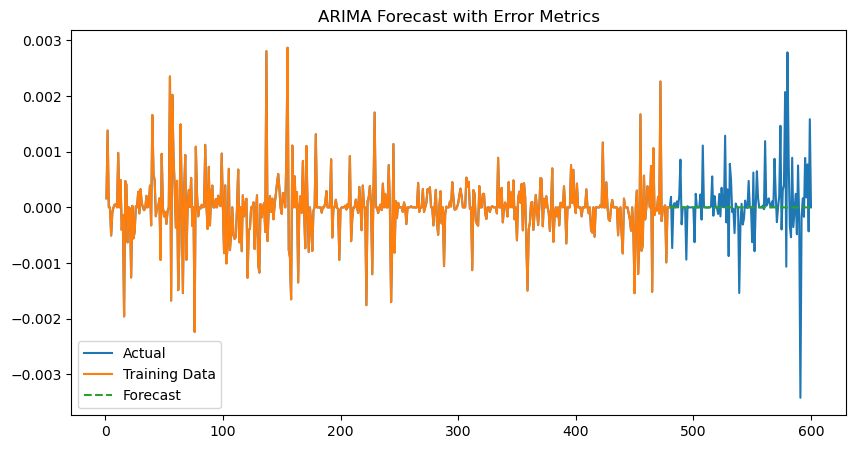

In [96]:
# JUST ARIMA ON MOST VOLATILE DATA
max_index = grouped_vol_aggs.index(max(grouped_vol_aggs))
key = list(selected_logr.keys())[max_index]
data = selected_logr[key].set_index('time')['log_return']

# Split data into train and test
split_point = int(len(data) * 0.8)
train_data = data[:split_point]
test_data = data[split_point:]

# Fit an ARIMA model on the training data
arima_model = auto_arima(train_data, error_action='ignore', suppress_warnings=True)
print(arima_model.summary())

# Forecast
forecast = arima_model.predict(n_periods=len(test_data))

# Calculate error metrics
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(data.index, data, label='Actual')
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(np.arange(split_point, split_point + len(test_data)), forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast with Error Metrics')
plt.legend()
plt.show()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -3319.185991166201
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3319.1859882559074
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Mean Squared Error, GARCH: 8.465426822011367e-08
Mean Absolute Error, GARCH: 0.00026680837794620737


/Users/roystonquek/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


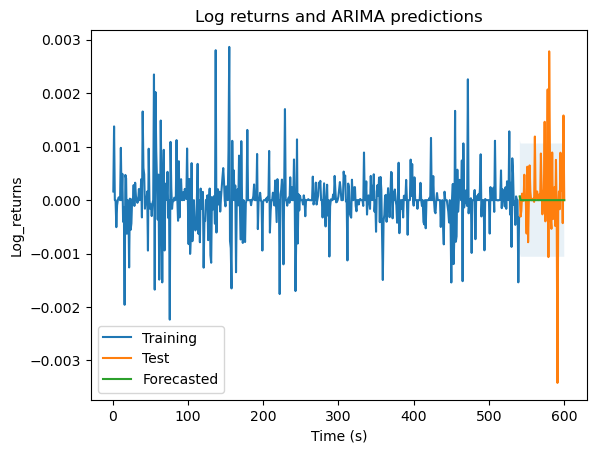

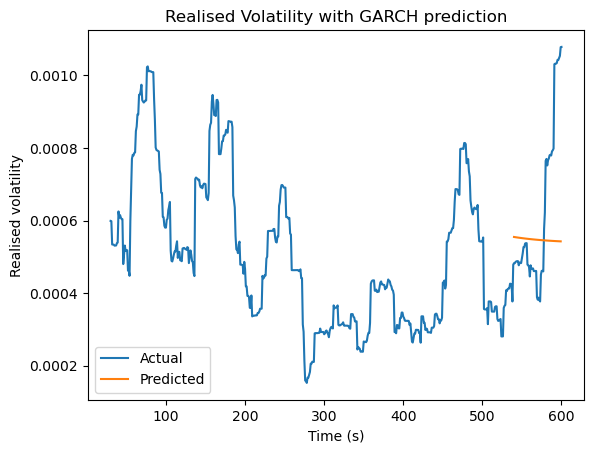

In [146]:
#ARMA-GARCH
key = list(selected_logr.keys())[max_index]
data_series = selected_logr[key].set_index('time')['log_return']

# Manually split data into train and test sets
train = data_series[:540]
test = data_series[540:]

# Fit ARIMA model on training set
model = auto_arima(train, seasonal = False, trace = False, error_action='ignore', suppress_warnings=True)

# Forecast the test set using ARIMA model
n_periods = len(test)
forecasts, conf_int = model.predict(n_periods = n_periods, return_conf_int=True)

# GARCH MODEL AND FORCEAST
garch_model = arch_model(model.resid(), vol='GARCH', q = 1)
garch_fit = garch_model.fit()
garch_forecast = garch_fit.forecast(horizon = n_periods)
predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])  # square root of the variance predictions

# REALISED VOLATILITY CALCULATIONS
window_size = 30
realised_volatility = data_series.rolling(window = window_size).std()
indices_last_60 = list(range(len(realised_volatility) - 59, len(realised_volatility)+1))
test_realised_volatility = realized_volatility[indices_last_60]
test_realised_volatility

# METRICS
mse = mean_squared_error(test_realised_volatility, predicted_volatility)
mae = mean_absolute_error(test_realised_volatility, predicted_volatility)
print(f'Mean Squared Error, GARCH: {mse}')
print(f'Mean Absolute Error, GARCH: {mae}')

# ARIMA VISUALISATIONS
plt.plot(train.index, train, label = 'Training')
plt.plot(test.index, test, label = 'Test')
plt.plot(test.index, forecasts, label = 'Forecasted')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], alpha = 0.1)
plt.title('Log returns and ARIMA predictions')
plt.xlabel('Time (s)')
plt.ylabel('Log_returns')
plt.legend()
plt.show()

# GARCH VISUALISATIONS
plt.plot(realised_volatility, label = 'Actual')
plt.plot(range(len(train), len(train) + n_periods), predicted_volatility, label = 'Predicted')
plt.title('Realised Volatility with GARCH prediction')
plt.xlabel('Time (s)')
plt.ylabel('Realised volatility')
plt.legend()
plt.show()

In [147]:
# Summary of the ARMA model
print(model.summary())

# Summary of the GARCH model
print(garch_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  540
Model:               SARIMAX(0, 0, 1)   Log Likelihood                3299.291
Date:                Tue, 07 May 2024   AIC                          -6594.582
Time:                        16:31:13   BIC                          -6585.999
Sample:                             0   HQIC                         -6591.226
                                - 540                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1315      0.035     -3.788      0.000      -0.200      -0.063
sigma2      2.873e-07    8.8e-09     32.663      0.000     2.7e-07    3.05e-07
Ljung-Box (L1) (Q):                   0.00   Jarque-

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3318.0394529321293
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3318.039453138508
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Mean Squared Error, FIGARCH: 7.716127761330867e-08
Mean Absolute Error, FIGARCH: 0.0002538806630067821


/Users/roystonquek/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


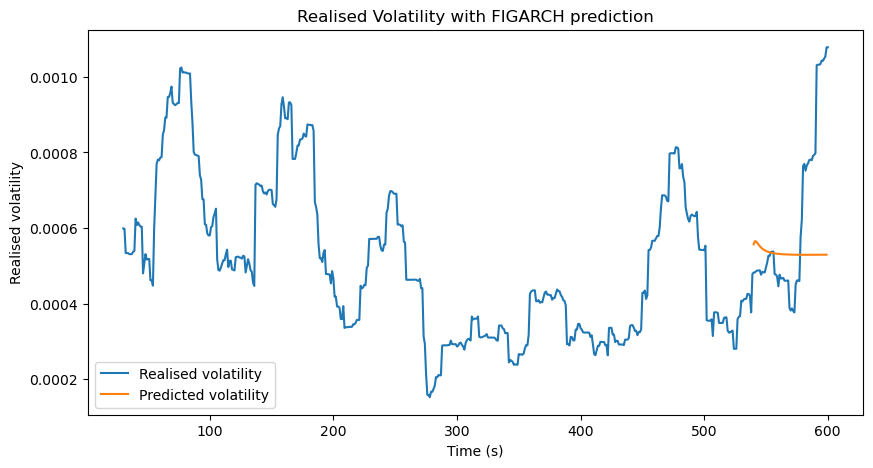

In [148]:
##  ARIMA-FIGARCH
# FIARCH MODEL AND FIGARCH PREDICTIONS
figarch_model = arch_model(model.resid(), vol = 'FIGARCH', q = 1)
figarch_fit = figarch_model.fit()
figarch_forecast = figarch_fit.forecast(horizon = n_periods)
predicted_volatility = np.sqrt(figarch_forecast.variance.values[-1, :])
forecasts, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# REALISED VOLATILITY CALCULATIONS
window_size = 30
realised_volatility = data_series.rolling(window = window_size).std()
indices_last_60 = list(range(len(realised_volatility) - 59, len(realised_volatility)+1))
test_realised_volatility = realized_volatility[indices_last_60]

# METRICS
mse = mean_squared_error(test_realised_volatility, predicted_volatility)
mae = mean_absolute_error(test_realised_volatility, predicted_volatility)
print(f'Mean Squared Error, FIGARCH: {mse}')
print(f'Mean Absolute Error, FIGARCH: {mae}')

# VISUALISATION
plt.figure(figsize = (10, 5))
plt.plot(realised_volatility, label = 'Realised volatility')
plt.plot(range(len(train), len(train) + n_periods), predicted_volatility, label = 'Predicted volatility')
plt.title('Realised Volatility with FIGARCH prediction')
plt.xlabel('Time (s)')
plt.ylabel('Realised volatility')
plt.legend()
plt.show()

In [149]:
# Summary of the FIGARCH model
print(figarch_fit.summary())

                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:                3318.04
Distribution:                  Normal   AIC:                          -6626.08
Method:            Maximum Likelihood   BIC:                          -6604.62
                                        No. Observations:                  540
Date:                Tue, May 07 2024   Df Residuals:                      539
Time:                        16:31:26   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.5316e-06  2.564e-06      0.597      0.550 